In [1]:
# Quantum
import pennylane as qml
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Numpy, Pandas
import numpy as np
import pandas as pd
# Layer
from kan import KAN
from RNN_block import RNN_block
# Data processing
from fucntions import data_seq,train_seq
from sklearn.preprocessing import MinMaxScaler

## Functions

- ansatz
- embedding
- fidelity
- quantum_layer_Z
- quantum_layer_prob
- quantum_circuit
- quantum_layer
- generate_tensor

In [2]:
n_qu = 4
dev = qml.device('default.qubit', wires=n_qu)

def ansatz(params, n_qu, all_entangled = False):
    # Length of Params : 3 * num_qubit
    for i in range(n_qu):
        qml.RX(params[:, 3*i], i)
        qml.RY(params[:, 3 * i + 1], i)
        qml.RZ(params[:, 3 * i + 2], i)
    for i in range(n_qu - 1):
        qml.CNOT([i, i + 1])
    if all_entangled:
        qml.CNOT([n_qu - 1, 0])

def embedding(params, n_qu):
    '''
    embedding layer
    '''
    n = n_qu
    for i in range(n):
        qml.Hadamard(i)
        qml.RZ(2.0 * params[:,i], i)
    
    for i in range(n - 1):
        qml.IsingZZ(2.0 * params[:,n + i] ,[i , i + 1])


@qml.qnode(dev, interface="torch")
def fidelity(vec1, vec2, n_qu):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    embedding(vec1, n_qu) # Phi(x1) circuit 적용
    qml.adjoint(embedding)(vec2, n_qu) # Phi^t(x2) 적용
    return qml.probs()

@qml.qnode(device=dev, interface='torch')
def quantum_layer_Z(mapped_data1, mapped_data2, parameter1, parameter2, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter1, n_qu = n_qu)
    qml.Barrier()
    embedding(params=mapped_data2, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter2, n_qu = n_qu)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qu)]

@qml.qnode(device=dev, interface='torch')
def quantum_layer_prob(mapped_data1, mapped_data2, parameter1, parameter2, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter1, n_qu=n_qu)
    qml.Barrier()
    embedding(params=mapped_data2, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter2, n_qu = n_qu)
    return [qml.expval((qml.PauliZ(i)+qml.Identity(i))/2) for i in range(n_qu)]

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs1,inputs2, weights1,weights2):
    block = RNN_block(4)
    block.embedding(inputs1)
    block.ansatz(weights1)
    block.embedding(inputs2)
    block.ansatz(weights2)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

def quantum_layer(inputs1,inputs2, weights1,weights2):
    return quantum_circuit(inputs1,inputs2, weights1,weights2)

def generate_tensor(seed, size):
    """
    주어진 시드와 크기에 맞게 torch.Tensor를 생성합니다.

    Args:
        seed (int): 시드 값
        size (tuple): 생성할 텐서의 크기

    Returns:
        torch.Tensor: 생성된 텐서
    """
    torch.manual_seed(seed)
    return torch.randn(size)

def get_data(model,train_loader,test_loader):
    pred_list = []
    train_label_list = []
    test_pred_list = []
    test_label_list = []
    for data,label in train_loader:
        pred = model(data)
        pred_list.append(pred.detach().numpy())
        train_label_list.append(label.numpy())
    for data,label in test_loader:
        pred = model(data)
        test_pred_list.append(pred.detach().numpy())
        test_label_list.append(label.numpy())

    return list(np.concatenate(pred_list).reshape(-1)),list(np.concatenate(train_label_list).reshape(-1)),list(np.concatenate(test_pred_list).reshape(-1)),list(np.concatenate(test_label_list).reshape(-1))

## Classes / NQE, RNNModel, RNN_layer

In [74]:
class NQE(nn.Module):
    def __init__(self, n_feature, mode : str):
        '''
            Args:
                type(str) : 'FC' or 'KAN'
                n_feature(int) : # of feature
        '''
        super(NQE, self).__init__()

        self.mode = mode

        if mode == 'FC':
            self.li1 = nn.Linear(n_feature, n_feature*2)
            self.li2 = nn.Linear(2*n_feature, n_feature**2)
            self.li3 = nn.Linear(n_feature**2, n_feature**2-n_feature)
            self.li4 = nn.Linear(n_feature**2-n_feature, 2 * n_feature)
            self.li5 = nn.Linear(2*n_feature, 2 * n_feature - 1)
        
        if mode == 'KAN':
            self.n_qu = n_feature
            self.linear1 = KAN([self.n_qu, self.n_qu * 2 + 1, self.n_qu * 2 - 1], grid = 1)
            self.quantum_layer = fidelity

    def forward_FC(self, inputs):
        inputs = self.li1(inputs)
        inputs = F.relu(inputs)
        inputs = self.li2(inputs)
        inputs = F.relu(inputs)
        inputs = self.li3(inputs)
        inputs = F.relu(inputs)
        inputs = self.li4(inputs)
        inputs = F.relu(inputs)
        inputs = self.li5(inputs)
        inputs = 2 * torch.pi * F.relu(inputs)
        ## Quantum Layer 추가 필요
        return inputs # Quantum Layer의 output을 리턴

    def forwad_KAN(self, inputs):
        input1 = inputs[0]
        input2 = inputs[1]
        input1 = self.linear1(input1)
        input2 = self.linear1(input2)
        output = self.quantum_layer(input1, input2, self.n_qu)[ : , 0]
        return output

    def forward(self, inputs):
        if self.mode == 'FC':
            return self.forward_FC(inputs)
        if self.mode == 'KAN':
            return self.forwad_KAN(inputs)
    

In [79]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0),self.hidden_size)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 사용
        return out
    
class RNN_layer(nn.Module):
    def __init__(self,input_size,output_size,num_layers,nQE_model=None):
        """_RNN layer 만든거_

        Args:
            input_size (_int_): _input feature의 개수_
            output_size (_int_): _output feature의 개수_
            num_layers (_int_): _필요한 RNN layer 수_
        """
        super(RNN_layer, self).__init__()
        self.linear = KAN([input_size,input_size*2-1],grid=1)
        self.input_size = input_size
        self.output_size = output_size
        self.num_layer = num_layers
        self.cls_layer = nn.Sequential(nn.Linear(4,16),nn.ReLU(),nn.Linear(16,1))
        ## QNE 수행할 Linear layer
        self.nqe_model = nQE_model

        ## Ansatz parameter
        self.ansatz_params_1 = nn.Parameter(torch.rand([24],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_2 = nn.Parameter(torch.rand([24],dtype = torch.float32),requires_grad=True)
        self.rnn_layer = quantum_layer


    def nQE_layer(self, input):
        if self.nqe_model == None:
            n_qu = input.shape[1]
            n_batch = input.shape[0]
            for i in range(n_qu-1):
                input = torch.cat(([input,((torch.pi-input[:,i])*(torch.pi-input[:,i+1])).reshape(n_batch,1)]),1)
            return input
        
        if self.nqe_model.mode == 'KAN':
            result = self.nqe_model.linear1(input)
            
        
        if self.nqe_model.mode == 'FC':
            result = self.nqe_model(input)
        return result
    

    def forward(self,inputs,return_hidden_list = False):
        """_summary_

        Args:
            inputs (_torch tensor_): _(batch,seq_len,feature_size)_
        """

        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        initial_t = generate_tensor(30,[inputs.shape[0],inputs.shape[2]*2-1]).float()
        inputs = inputs.permute(1, 0, 2)
        ## inputs  = (seq_len,batch,feature_size)
        input = self.nQE_layer(inputs[0])
        
        hidden = torch.stack(self.rnn_layer(initial_t,input,self.ansatz_params_1,self.ansatz_params_2),dim=1).float()
        hidden = hidden.to(torch.float32)
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = self.nQE_layer(input)
            hidden = self.linear(hidden)
            hidden = torch.stack(self.rnn_layer(hidden,input,self.ansatz_params_1,self.ansatz_params_2),dim=1).float()
            hidden = hidden.to(torch.float32)
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list,hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch,seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden)

## Data uploading

In [80]:
import pickle
with open('train_data_NQE.pkl','rb') as file:
    data_dict = pickle.load(file)

train_loader,test_loader = data_dict['train'],data_dict['test']

## Model, NQE model, criterion, optimizer

In [81]:
my_nqe = NQE(n_feature=n_qu,mode='FC')
my_nqe.load_state_dict(torch.load('./model_0001_fc_5_purefidelity.pth'))

model = RNN_layer(4,1,5, nQE_model=my_nqe)
#model = RNNModel(4,32,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

## Train

In [82]:
train_corpus = train_seq(model, train_loader, test_loader)

train_loss_list, test_loss_list = train_corpus.train(500,optimizer,criterion)

epoch : 1 loss :0.71340012550354 loss_test = 0.5497932434082031
epoch : 2 loss :0.4175713062286377 loss_test = 0.2877243161201477
epoch : 3 loss :0.17680741846561432 loss_test = 0.10526594519615173
epoch : 4 loss :0.0681636705994606 loss_test = 0.05860542878508568
epoch : 5 loss :0.048774100840091705 loss_test = 0.04787803813815117
epoch : 6 loss :0.043309129774570465 loss_test = 0.04443778097629547
epoch : 7 loss :0.0407111831009388 loss_test = 0.043012835085392
epoch : 8 loss :0.038908712565898895 loss_test = 0.04095560684800148
epoch : 9 loss :0.03668365254998207 loss_test = 0.03989402577280998
epoch : 10 loss :0.03469886630773544 loss_test = 0.03766479343175888
epoch : 11 loss :0.03258431330323219 loss_test = 0.036047980189323425
epoch : 12 loss :0.030590824782848358 loss_test = 0.03361548110842705
epoch : 13 loss :0.028117602691054344 loss_test = 0.031175052747130394
epoch : 14 loss :0.025795748457312584 loss_test = 0.029556315392255783
epoch : 15 loss :0.023611702024936676 loss_t

## Plotting

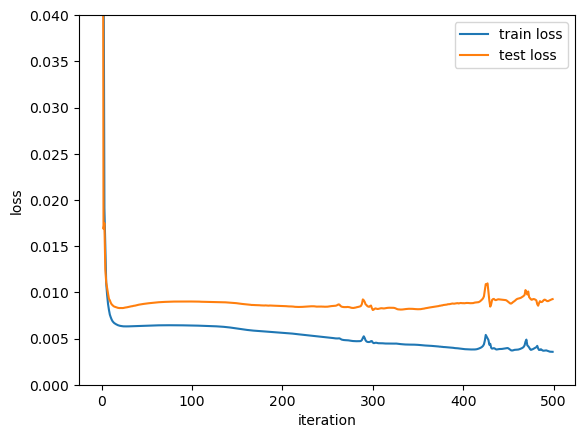

In [69]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label = 'train loss')
plt.ylim(0,0.04)
plt.plot(test_loss_list, label = 'test loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend()

## MSE

In [63]:
def decoding(input,max_value):
  max = 1754.882
  min = 85.192
  return (max-min)/max_value*input+min

for feature,label in test_loader:
    pred = decoding(model(feature),1)
    true = decoding(label,1)
    print(nn.MSELoss()(true,pred))
    break

tensor(22270.1816, grad_fn=<MseLossBackward0>)


예시 : pd.DataFrame{’tain_loss’:train_loss,…..}

저장할때 index = False 해야함

data.to_csv(’경로명’,index=False)

폴더명 :  result_data

파일명 : <model_name>_<method_name>_data.csv

In [64]:
pred_list, train_label_list, test_pred_list, test_label_list = get_data(model=model, train_loader=test_loader, test_loader=test_loader)

data_df = pd.DataFrame({'train_loss': train_loss_list, 'test_loss':test_loss_list,'train_predict':pred_list,'train_label':train_label_list,'validation_pred':test_pred_list,'validation_label':test_label_list})

In [65]:
print(data_df)

                       0                                                  1
0             train_loss  [0.7028571963310242, 0.26157712936401367, 0.05...
1         test_loss_list  [0.4050746560096741, 0.09366366267204285, 0.01...
2          train_predict  [0.5189198, 0.63135177, 0.5798306, 0.6479473, ...
3       train_label_list  [0.6068493, 0.6901615, 0.7628788, 0.8246914, 0...
4   validation_pred_list  [0.5189198, 0.63135177, 0.5798306, 0.6479473, ...
5  validation_label_list  [0.6068493, 0.6901615, 0.7628788, 0.8246914, 0...


In [66]:
data_df.to_csv('./result_data_ysj/qRNN_NQEKAN_mse22270._data.csv',index=False)